# Fraud Detection
Mohamed Bani Hani

---
## Application on the detecting Fraudulent transactions
---
## Dataset Overview
* step:	Maps a unit of time in the real world. 1 step = 1 hour of time.

* Customer	Unique customer ID associated with each transaction.
* zipCodeOrigin	The zip code of the transaction's origin/source.
* Merchant	The unique ID of the merchant involved in the transaction.
* zipMerchant	The zip code of the merchant.
* Age	Categorized age of the customer:
	1. 0: <= 18
	2. 1: 19-25
	3. 2: 26-35
	4. 3: 36-45
	5. 4: 46-55
	6. 5: 56-65
	7. 6: > 65
	8. U: Unknown
* Gender	Gender of the customer:
	1. E: Enterprise
	2. F: Female
	3. M: Male
	4. U: Unknown
* Category	Category of the purchase.
* Amount	The amount of the purchase.



# Importing libraries

In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [75]:
df = pd.read_csv("/content/sample_data/fraud (1).csv")

In [76]:
rows = df.shape[0]
column = df.shape[1]
print("There are {} rows and {} columns.".format(rows,column))

There are 594643 rows and 10 columns.


In [77]:
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


## EDA

In [78]:
df.dtypes.sort_values()

step             int64
fraud            int64
amount         float64
customer        object
age             object
gender          object
zipcodeOri      object
merchant        object
zipMerchant     object
category        object
dtype: object

In [79]:
df.describe()
# the amount details shows a right skew of data which measn outliers

,step,amount,fraud
count,594643.000000,594643.000000,594643.000000
mean,94.986827,37.890135,0.012108
std,51.053632,111.402831,0.109369
min,0.000000,0.000000,0.000000
25%,52.000000,13.740000,0.000000
50%,97.000000,26.900000,0.000000
75%,139.000000,42.540000,0.000000
max,179.000000,8329.960000,1.000000


In [80]:
df.describe(include = 'O')
# zipcodeOri and zipMerchant should be removed

,customer,age,gender,zipcodeOri,merchant,zipMerchant,category
count,594643,594643,594643,594643,594643,594643,594643
unique,4112,8,4,1,50,1,15
top,'C1978250683','2','F','28007','M1823072687','28007','es_transportation'
freq,265,187310,324565,594643,299693,594643,505119


In [81]:
# Data Cleaning
df['category'] = df['category'].str[1:-1]
df['category'] = df['category'].str.replace('es_', '')
df = df.drop(['zipcodeOri','zipMerchant'],axis=1)

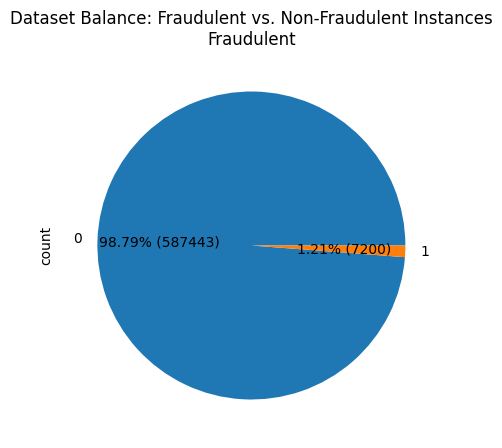

In [82]:
# Calculate the counts of fraudulent and non-fraudulent instances
# in order to determine if the dataset is balanced or unbalanced
fraud_counts = df['fraud'].sum()
non_fraud_counts = len(df) - fraud_counts

fraud_percentage = (fraud_counts / len(df)) * 100
non_fraud_percentage = 100 - fraud_percentage

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

df.fraud.value_counts().plot(x=None, y=None, kind='pie', autopct=lambda p: '{:.2f}% ({:.0f})'.format(p, p * sum(df.fraud.value_counts()) / 100))
plt.title('Dataset Balance: Fraudulent vs. Non-Fraudulent Instances\nFraudulent')
plt.show()


In [83]:
stats = df.groupby('fraud')['amount'].agg(['mean', 'std', 'count']).reset_index()
stats

,fraud,mean,std,count
0,0,31.847230,31.470876,587443
1,1,530.926551,835.587112,7200


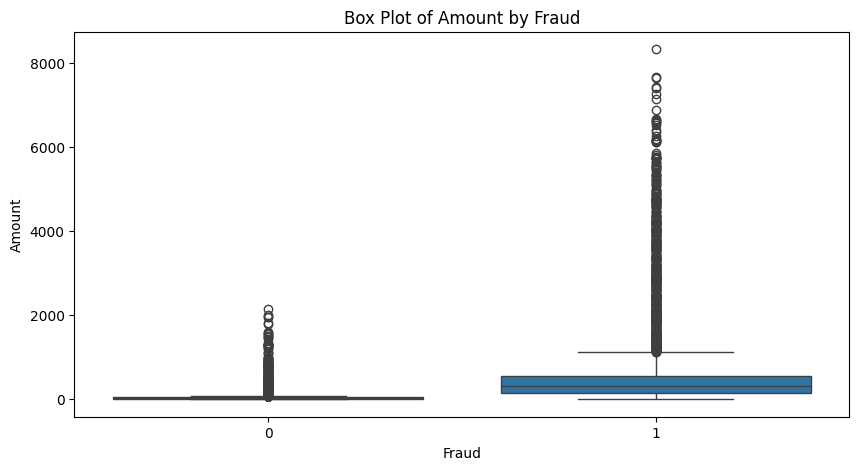

In [84]:
# Box plot to compare distributions
plt.figure(figsize=(10, 5))
sns.boxplot(x='fraud', y='amount', data=df)
plt.title('Box Plot of Amount by Fraud')
plt.xlabel('Fraud')
plt.ylabel('Amount')
plt.show()

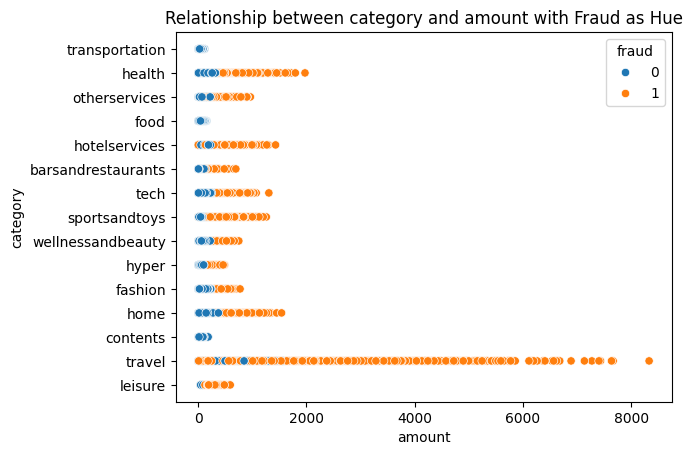

In [85]:
sns.scatterplot(x='amount', y='category', hue='fraud', data=df, marker='o')
plt.title('Relationship between category and amount with Fraud as Hue')
plt.show()


In [86]:
# Create Amount Thresholds
conditions = [
    (df['amount'] <= 500),
    (df['amount'] > 500) & (df['amount'] <= 1000),
    (df['amount'] > 1000) & (df['amount'] <= 1500),
    (df['amount'] > 1500) & (df['amount'] <= 2000),
    (df['amount'] > 2000) & (df['amount'] <= 2500),
    (df['amount'] > 2500) & (df['amount'] <= 3000),
    (df['amount'] > 3000)
]
order = ['0-500', '500-1000', '1000-1500', '1500-2000', '2000-2500', '2500-3000', '>3000']

df['amount_thresh'] = np.select(conditions, order, default=np.nan)

In [87]:
amount_thresh = df.groupby(['amount_thresh','fraud'])['amount'].mean().reset_index().rename(columns={'amount_thresh': 'Value', 'amount': 'avg_spent'})
amount_thresh['Metric'] = 'amount_thresh'

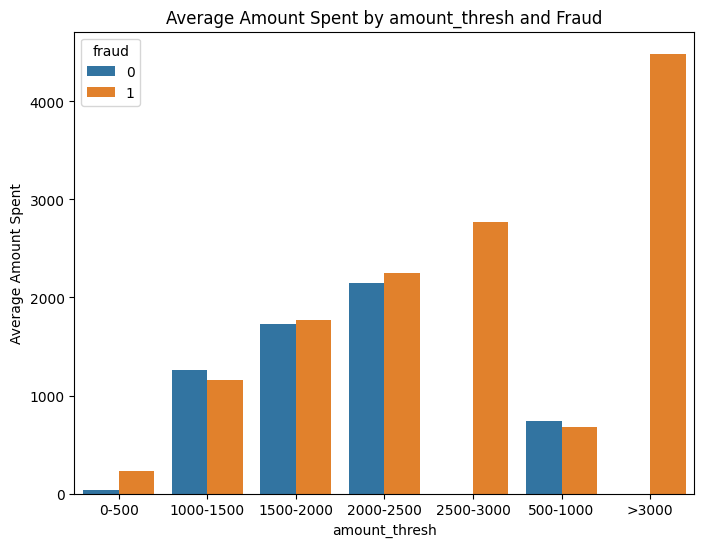

In [88]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Value', y='avg_spent', hue='fraud', data=amount_thresh)
plt.title('Average Amount Spent by amount_thresh and Fraud')
plt.xlabel('amount_thresh')
plt.ylabel('Average Amount Spent')
plt.show()


In [89]:
gender = df.groupby(['gender','fraud'])['amount'].mean().reset_index().rename(columns={'gender': 'Value', 'amount': 'avg_spent'})
gender['Metric'] = 'Gender'

In [90]:
gender

,Value,fraud,avg_spent,Metric
0,'E',0,34.016336,Gender
1,'E',1,473.458571,Gender
2,'F',0,31.968111,Gender
3,'F',1,526.178188,Gender
4,'M',0,31.692975,Gender
5,'M',1,540.370078,Gender
6,'U',0,31.508932,Gender


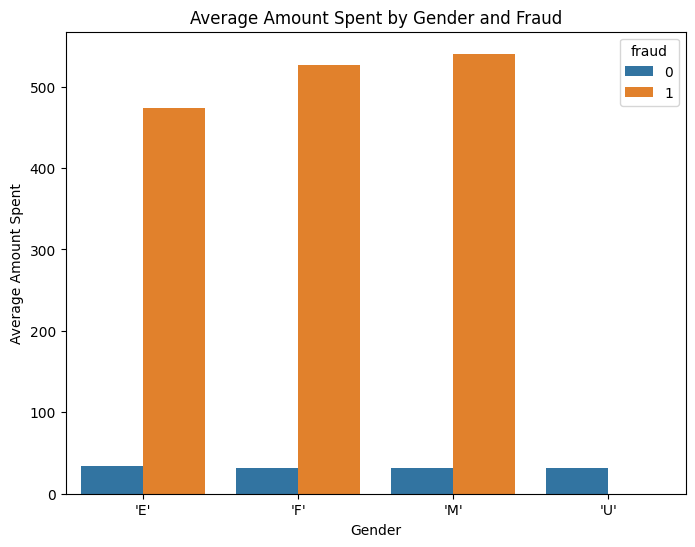

In [91]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Value', y='avg_spent', hue='fraud', data=gender)
plt.title('Average Amount Spent by Gender and Fraud')
plt.xlabel('Gender')
plt.ylabel('Average Amount Spent')
plt.show()


In [92]:
total_count = df.shape[0]

grouped = df.groupby(['gender', 'fraud']).size().reset_index(name='Count')
pivot_df = grouped.pivot(index='gender', columns='fraud', values='Count').fillna(0)
pivot_df.columns = ['Non_Fraud', 'fraud']
pivot_df = pivot_df.reset_index()

pivot_df['Total'] = pivot_df['Non_Fraud'] + pivot_df['fraud']
total_count = pivot_df['Total'].sum()
pivot_df['Total_Percentage'] = (pivot_df['Total'] / total_count) * 100
pivot_df['Fraud_Percentage'] = (pivot_df['fraud'] /total_count) * 100
pivot_df['Fraud_Percentage_cat'] = (pivot_df['fraud'] /pivot_df['Total']) * 100

pivot_df


,gender,Non_Fraud,fraud,Total,Total_Percentage,Fraud_Percentage,Fraud_Percentage_cat
0,'E',1171.0,7.0,1178.0,0.198102,0.001177,0.594228
1,'F',319807.0,4758.0,324565.0,54.581488,0.800144,1.465962
2,'M',265950.0,2435.0,268385.0,45.133803,0.409489,0.907279
3,'U',515.0,0.0,515.0,0.086607,0.000000,0.000000


In [93]:
age = df.groupby(['age','fraud'])['amount'].mean().reset_index().rename(columns={'age': 'Value', 'amount': 'avg_spent'})
age['Metric'] = 'Gender'

In [94]:
age

,Value,fraud,avg_spent,Metric
0,'0',0,34.409713,Gender
1,'0',1,657.278125,Gender
2,'1',0,31.986634,Gender
3,'1',1,499.757692,Gender
4,'2',0,31.846593,Gender
5,'2',1,552.212432,Gender
6,'3',0,31.909451,Gender
7,'3',1,532.428758,Gender
8,'4',0,31.857414,Gender
9,'4',1,522.400915,Gender


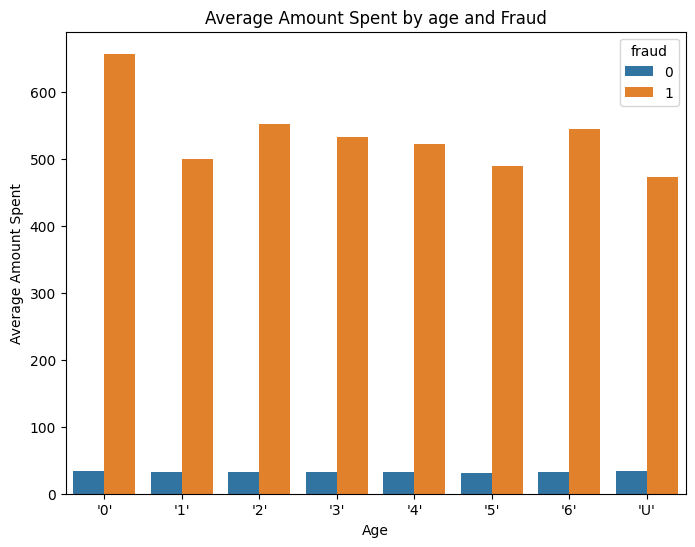

In [95]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Value', y='avg_spent', hue='fraud', data=age)
plt.title('Average Amount Spent by age and Fraud')
plt.xlabel('Age')
plt.ylabel('Average Amount Spent')
plt.show()


In [96]:
total_count = df.shape[0]

grouped = df.groupby(['age', 'fraud']).size().reset_index(name='Count')

pivot_df = grouped.pivot(index='age', columns='fraud', values='Count').fillna(0)
pivot_df.columns = ['Non_Fraud', 'fraud']
pivot_df = pivot_df.reset_index()

pivot_df['Total'] = pivot_df['Non_Fraud'] + pivot_df['fraud']
total_count = pivot_df['Total'].sum()
pivot_df['Total_Percentage'] = (pivot_df['Total'] / total_count) * 100

pivot_df['Fraud_Percentage'] = (pivot_df['fraud'] /total_count) * 100
pivot_df['Fraud_Percentage_cat'] = (pivot_df['fraud'] /pivot_df['Total']) * 100

pivot_df


,age,Non_Fraud,fraud,Total,Total_Percentage,Fraud_Percentage,Fraud_Percentage_cat
0,'0',2404,48,2452,0.412348,0.008072,1.957586
1,'1',57442,689,58131,9.775781,0.115868,1.185254
2,'2',184966,2344,187310,31.499572,0.394186,1.251401
3,'3',145376,1755,147131,24.742745,0.295135,1.192815
4,'4',107615,1410,109025,18.334530,0.237117,1.293281
5,'5',61956,686,62642,10.534388,0.115363,1.095112
6,'6',26513,261,26774,4.502533,0.043892,0.974826
7,'U',1171,7,1178,0.198102,0.001177,0.594228


In [97]:
category = df.groupby(['category','fraud'])['amount'].mean().reset_index().rename(columns={'category': 'Value', 'amount': 'avg_spent'})
category['Metric'] = 'Gender'
category

,Value,fraud,avg_spent,Metric
0,barsandrestaurants,0,41.145997,Gender
1,barsandrestaurants,1,164.092667,Gender
2,contents,0,44.547571,Gender
3,fashion,0,62.347674,Gender
4,fashion,1,247.008190,Gender
5,food,0,37.070405,Gender
6,health,0,103.737228,Gender
7,health,1,407.031338,Gender
8,home,0,113.338409,Gender
9,home,1,457.484834,Gender


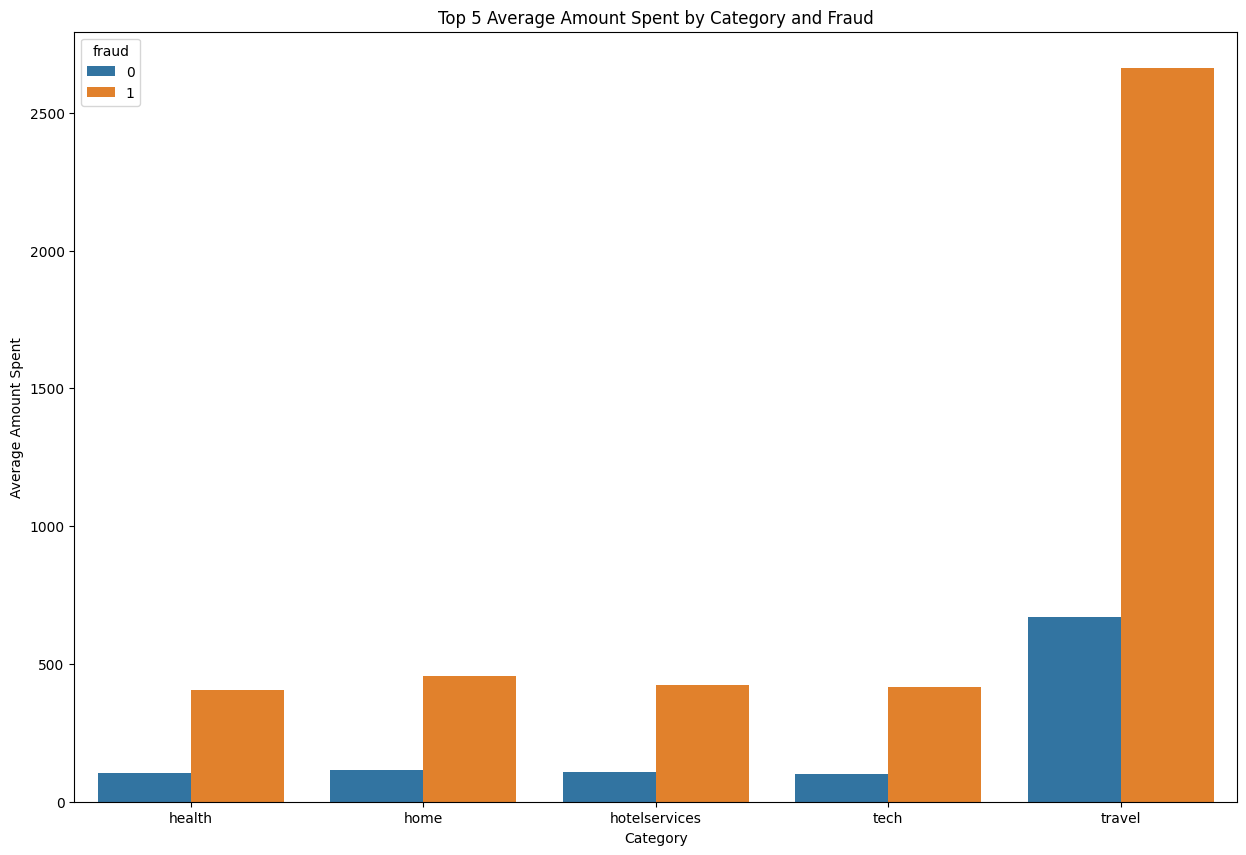

In [98]:
category_avg = category.groupby('Value')['avg_spent'].mean().sort_values(ascending=False)

top_5_categories = category_avg.head(5).index

top_5_category = category[category['Value'].isin(top_5_categories)]

plt.figure(figsize=(15, 10))
sns.barplot(x='Value', y='avg_spent', hue='fraud', data=top_5_category)
plt.title('Top 5 Average Amount Spent by Category and Fraud')
plt.xlabel('Category')
plt.ylabel('Average Amount Spent')
plt.show()

In [99]:
total_count = df.shape[0]
grouped = df.groupby(['category', 'fraud']).size().reset_index(name='Count')

pivot_df = grouped.pivot(index='category', columns='fraud', values='Count').fillna(0)
pivot_df.columns = ['Non_Fraud', 'fraud']
pivot_df = pivot_df.reset_index()
pivot_df['Total'] = pivot_df['Non_Fraud'] + pivot_df['fraud']
total_count = pivot_df['Total'].sum()
pivot_df['Total_Percentage'] = (pivot_df['Total'] / total_count) * 100
pivot_df['Fraud_Percentage'] = (pivot_df['fraud'] /total_count) * 100
pivot_df['Fraud_Percentage_cat'] = (pivot_df['fraud'] /pivot_df['Total']) * 100
pivot_df


,category,Non_Fraud,fraud,Total,Total_Percentage,Fraud_Percentage,Fraud_Percentage_cat
0,barsandrestaurants,6253.0,120.0,6373.0,1.071735,0.020180,1.882944
1,contents,885.0,0.0,885.0,0.148829,0.000000,0.000000
2,fashion,6338.0,116.0,6454.0,1.085357,0.019508,1.797335
3,food,26254.0,0.0,26254.0,4.415086,0.000000,0.000000
4,health,14437.0,1696.0,16133.0,2.713056,0.285213,10.512614
5,home,1684.0,302.0,1986.0,0.333982,0.050787,15.206445
6,hotelservices,1196.0,548.0,1744.0,0.293285,0.092156,31.422018
7,hyper,5818.0,280.0,6098.0,1.025489,0.047087,4.591669
8,leisure,25.0,474.0,499.0,0.083916,0.079712,94.989980
9,otherservices,684.0,228.0,912.0,0.153369,0.038342,25.000000


In [ ]:
# if F or M  and age 0 and 2 and 3 andd 5  and travel then 80% fraud
#  if F or M  and age 0 and 2 and 3 andd 5  and travel and amount >= 2500 then 100% fraud

In [62]:
'''
def get_time_of_day(step):
    step = step % 24
    if 0 <= step < 6:
        return 'Night'
    elif 6 <= step < 12:
        return 'Morning'
    elif 12 <= step < 18:
        return 'Afternoon'
    else:
        return 'Evening'
df['time_of_day'] = df['step'].apply(get_time_of_day)
'''

In [ ]:
'''
category = df.groupby(['time_of_day','fraud'])['amount'].mean().reset_index().rename(columns={'time_of_day': 'Value', 'amount': 'avg_spent'})
category['Metric'] = 'time_of_day'
category
'''

In [ ]:
'''
category_avg = category.groupby('Value')['avg_spent'].mean().sort_values(ascending=False)
top_5_categories = category_avg.head(5).index
top_5_category = category[category['Value'].isin(top_5_categories)]
plt.figure(figsize=(15, 10))
sns.barplot(x='Value', y='avg_spent', hue='fraud', data=top_5_category)
plt.title('Top 5 Average Amount Spent by Category and Fraud')
plt.xlabel('Category')
plt.ylabel('Average Amount Spent')
plt.show()
'''

In [ ]:
'''
sns.scatterplot(x='time_of_day', y='amount', hue='fraud', data=df, marker='o')
plt.title('Relationship between step and amount with Fraud as Hue')
plt.show()
'''

In [100]:
col_categorical = df.select_dtypes(include= ['object']).columns
for col in col_categorical:
    df[col] = df[col].astype('category')
df[col_categorical] = df[col_categorical].apply(lambda x: x.cat.codes)
df.head(5)

,step,customer,age,gender,merchant,category,amount,fraud,amount_thresh
0,0,210,4,2,30,12,4.55,0,0
1,0,2753,2,2,30,12,39.68,0,0
2,0,2285,4,1,18,12,26.89,0,0
3,0,1650,3,2,30,12,17.25,0,0
4,0,3585,5,2,30,12,35.72,0,0


In [107]:
col = "fraud"
df1 = df.loc[:, df.columns != col]

df1.head()

,step,customer,age,gender,merchant,category,amount,amount_thresh
0,0,210,4,2,30,12,4.55,0
1,0,2753,2,2,30,12,39.68,0
2,0,2285,4,1,18,12,26.89,0
3,0,1650,3,2,30,12,17.25,0
4,0,3585,5,2,30,12,35.72,0


Text(0.5, 1.0, 'Correlation with fraud \n')

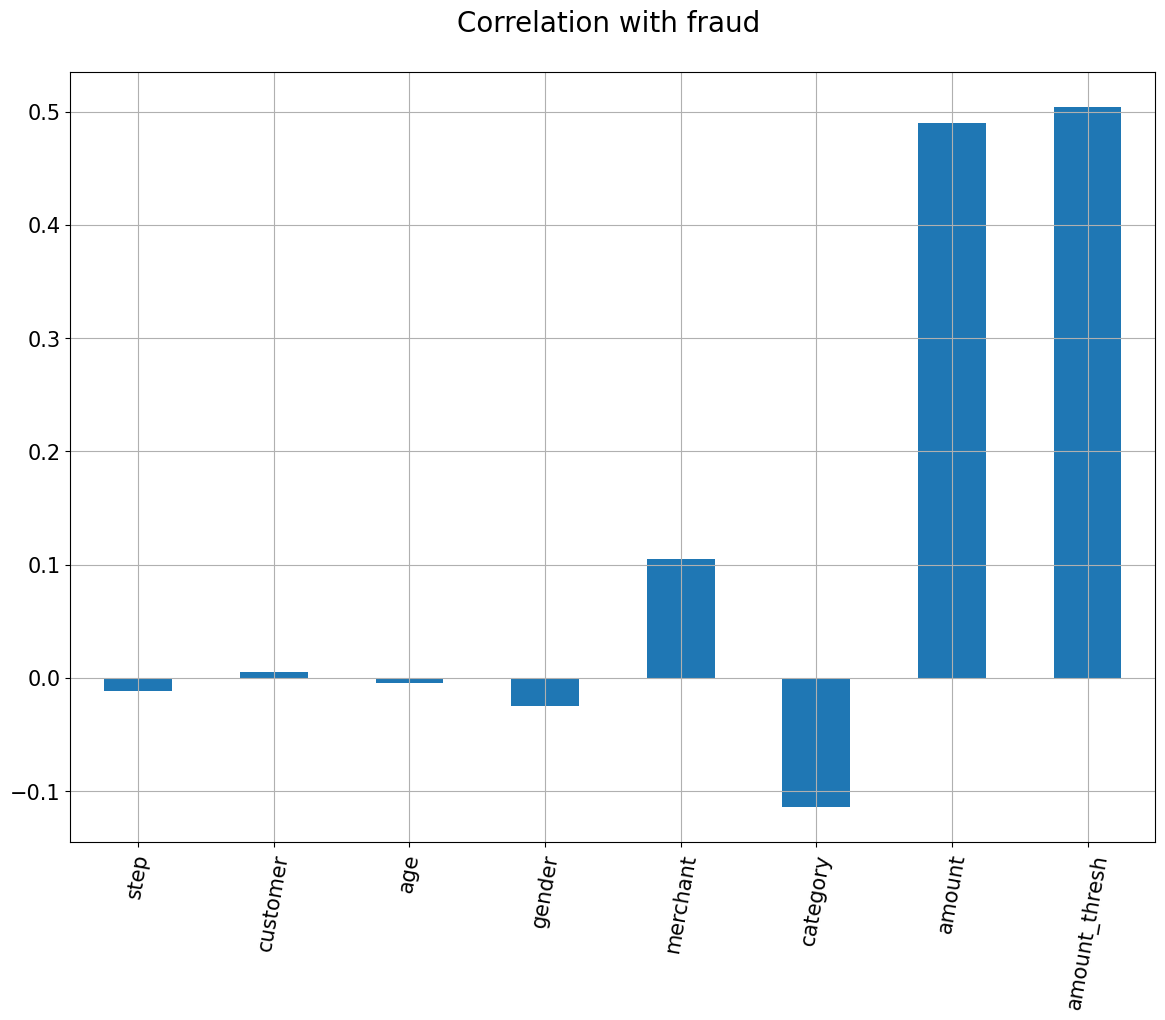

In [108]:
correlations = df1.corrwith(df.fraud)
correlations = correlations[correlations!=1]
correlations.plot.bar(
        figsize = (14, 10),
        fontsize = 15,
        rot = 80, grid = True)
plt.title('Correlation with fraud \n',
horizontalalignment="center", fontstyle = "normal",
fontsize = "20", fontfamily = "sans-serif")

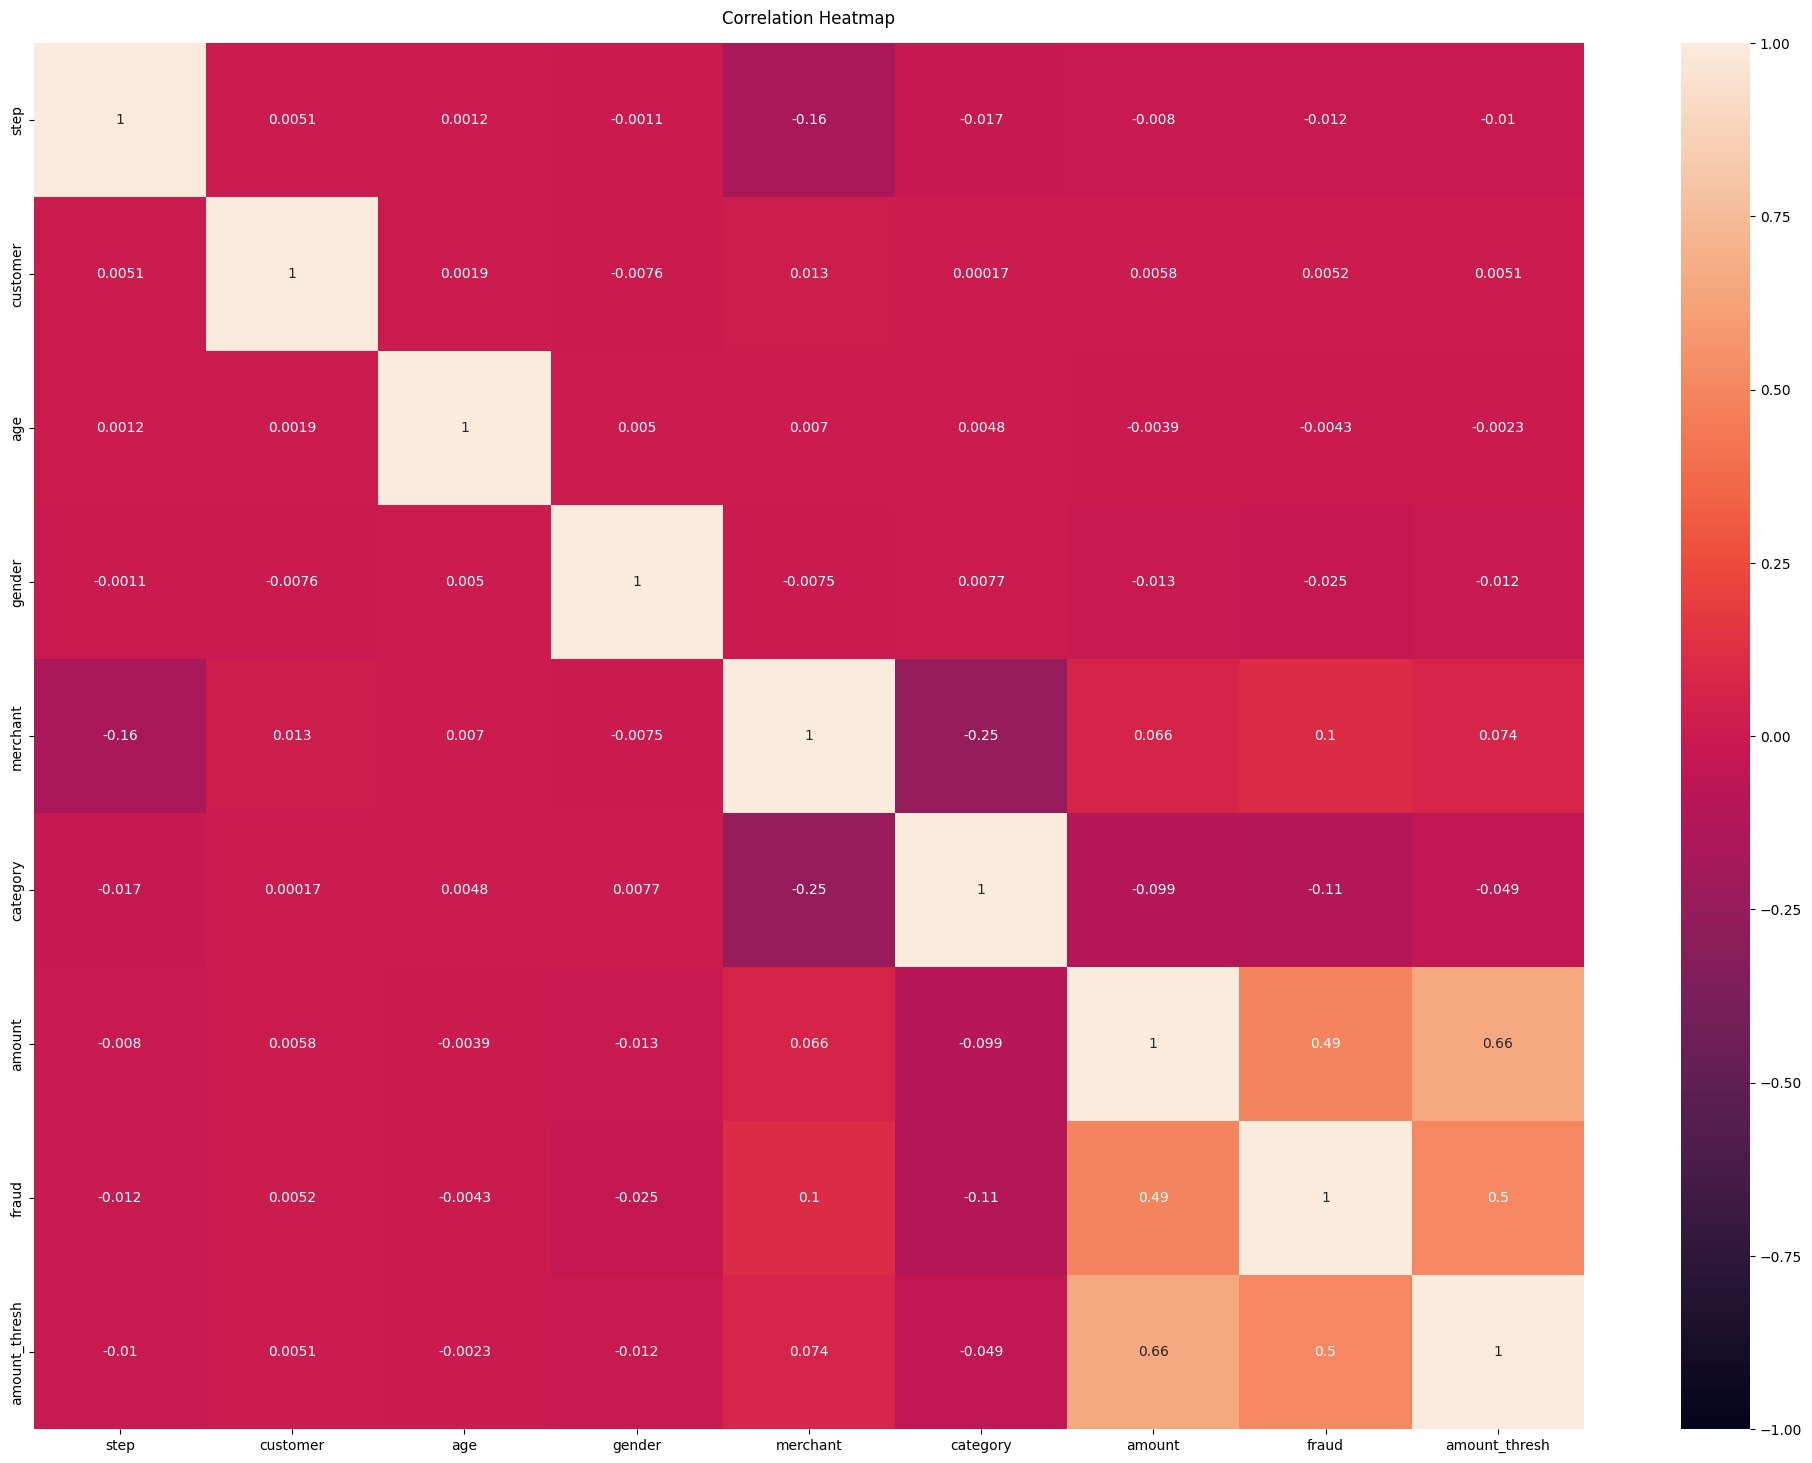

In [109]:
# in this step i wanted to see the correlation between all the featuers
# this would help in detecting hight correlation that could be removed from the dataset
plt.figure(figsize=(25, 18))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=14);

In [101]:
X = df.drop(['fraud','customer'],axis=1)
y = df['fraud']
print(X.head(),"\n")
print(y.head())


   step  age  gender  merchant  category  amount  amount_thresh
0     0    4       2        30        12    4.55              0
1     0    2       2        30        12   39.68              0
2     0    4       1        18        12   26.89              0
3     0    3       2        30        12   17.25              0
4     0    5       2        30        12   35.72              0 

0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64


In [102]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
y_res = pd.DataFrame(y_res)

(array([587443.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 587443.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

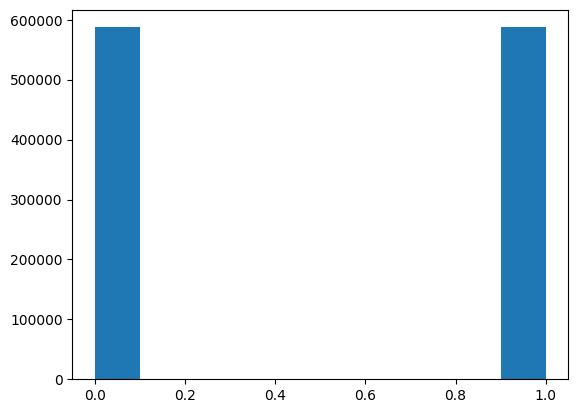

In [103]:
plt.hist(y_res)

In [104]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)

In [110]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (822420, 7)
Number transactions y_train dataset:  (822420, 1)
Number transactions X_test dataset:  (352466, 7)
Number transactions y_test dataset:  (352466, 1)


In [114]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
acc_log_reg = accuracy_score(y_test, y_pred_log_reg)
prec_log_reg = precision_score(y_test, y_pred_log_reg)
rec_log_reg = recall_score(y_test, y_pred_log_reg)

# Decision Tree
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train, y_train)
y_pred_dec_tree = dec_tree.predict(X_test)
acc_dec_tree = accuracy_score(y_test, y_pred_dec_tree)
prec_dec_tree = precision_score(y_test, y_pred_dec_tree)
rec_dec_tree = recall_score(y_test, y_pred_dec_tree)

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb)
rec_xgb = recall_score(y_test, y_pred_xgb)

# Creating the results table
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'XGBoost'],
    'Accuracy': [acc_log_reg, acc_dec_tree, acc_xgb],
    'Precision': [prec_log_reg, prec_dec_tree, prec_xgb],
    'Recall': [rec_log_reg, rec_dec_tree, rec_xgb]
})

print(results)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                 Model  Accuracy  Precision    Recall
0  Logistic Regression  0.922024   0.950501  0.890418
1        Decision Tree  0.994743   0.992777  0.996737
2              XGBoost  0.991852   0.987904  0.995897


In [117]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, None],
    'max_leaf_nodes': [None, 10, 20, 50, 100]
}

dec_tree = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator=dec_tree, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': None}
Accuracy: 0.9950
Precision: 0.9930
Recall: 0.9971


Accuracy: 0.9950
Precision: 0.9930
Recall: 0.9970


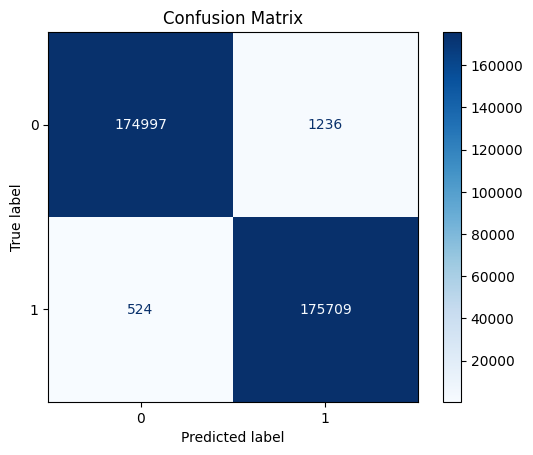

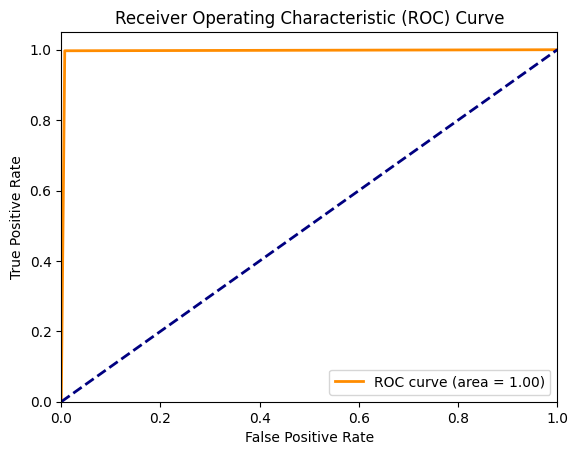

In [119]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay

best_model = DecisionTreeClassifier(criterion='entropy', max_depth=None, max_leaf_nodes=None)
best_model.fit(X_train, y_train)

# Predict on the test data
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)  # Change the color here, for example, to Blues
plt.title("Confusion Matrix")
plt.show()


# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [124]:
# Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(importance_df)


         Feature  Importance
5         amount    0.647667
4       category    0.188688
3       merchant    0.125710
0           step    0.020696
2         gender    0.010439
1            age    0.006735
6  amount_thresh    0.000066
